In [1]:
%%capture capt
!pip install matplotlib
!pip install pandas
!pip install seaborn
!pip install scikit-learn
!pip install chess
!pip install tensorflow
!pip install tensorflow_addons

In [2]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm
from collections import Counter
import time
import seaborn as sns
import math

import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score

import chess

# Load data

In [3]:
%run S3.ipynb

In [4]:
#moves_df = pd.read_csv("../Data/moves_df.csv")
moves_df = open_csv("moves_df_rnd.csv")

In [5]:
moves_df

,evaluation,fen
0,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...
1,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...
2,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...
3,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...
4,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...
...,...,...
17152758,9600,2b2r2/3p1p2/1rNQpk2/ppp4p/2P4P/PPRPPNP1/1b2B3/...
17152759,1201,2b2r2/3p1p2/1rN1pk2/ppp4p/2P2Q1P/PPRPPNP1/1b2B...
17152760,1285,2b2r2/3p1pk1/1rN1p3/ppp4p/2P2Q1P/PPRPPNP1/1b2B...
17152761,688,2b2r2/3p1pk1/1rN1p3/ppp4p/2PP1Q1P/PPR1PNP1/1b2...


# Remove duplicates

In [16]:
moves_df.drop_duplicates(subset=["fen"], inplace=True)

In [17]:
moves_df

,evaluation,fen
0,35,rnbqkbnr/pppppppp/8/8/4P3/8/PPPP1PPP/RNBQKBNR ...
1,48,rnbqkbnr/pppp1ppp/8/4p3/4P3/8/PPPP1PPP/RNBQKBN...
2,111,rnbqkbnr/pppp1ppp/8/4p3/4P3/5N2/PPPP1PPP/RNBQK...
3,47,r1bqkbnr/pppp1ppp/2n5/4p3/4P3/5N2/PPPP1PPP/RNB...
4,52,r1bqkbnr/pppp1ppp/2n5/1B2p3/4P3/5N2/PPPP1PPP/R...
...,...,...
13322434,9600,2b2r2/3p1p2/1rNQpk2/ppp4p/2P4P/PPRPPNP1/1b2B3/...
13322435,1144,2b2r2/3p1p2/1rN1pk2/ppp4p/2P2Q1P/PPRPPNP1/1b2B...
13322436,1207,2b2r2/3p1pk1/1rN1p3/ppp4p/2P2Q1P/PPRPPNP1/1b2B...
13322437,688,2b2r2/3p1pk1/1rN1p3/ppp4p/2PP1Q1P/PPR1PNP1/1b2...


# Analyze y

In [18]:
y = np.array(moves_df.evaluation)

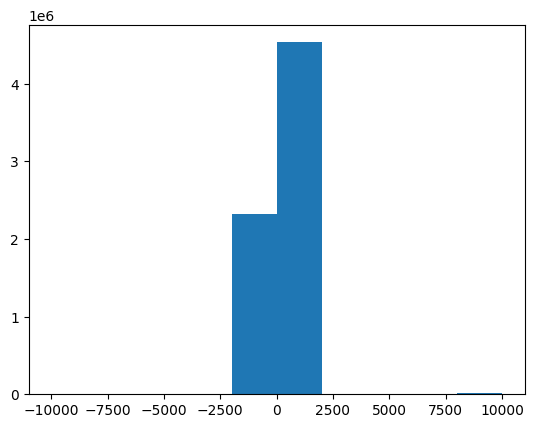

In [19]:
plt.hist(y, bins=10);

## Get number of positions per evaluation range

In [20]:
y.sort()

In [21]:
def get_by_range(y, min_, max_, index=0):
    # return the nb of evaluations that are such that min_ <= x < max_
    # y has been sorted, index is the index at which the previous call has stopped, for the previous range
    
    nb = 0
    for i in range(index, len(y)):
        if min_ <= y[i] and y[i] < max_:
            nb += 1
        if y[i] >= max_:
            return nb, i
    return nb, i

In [22]:
min_y, max_y = np.min(y), np.max(y)

In [23]:
nb_per_range, ranges = [], []
index = 0
min_range, max_range = min_y, min_y+50

nb, index = get_by_range(y, min_range, max_range, index=index)
nb_per_range.append(nb)
ranges.append(range(min_range, max_range))

# we go 50 by 50
while index < len(y)-1:
    min_range, max_range = min_range+50, max_range+50
    nb, index = get_by_range(y, min_range, max_range, index=index)
    nb_per_range.append(nb)
    ranges.append(range(min_range, max_range))

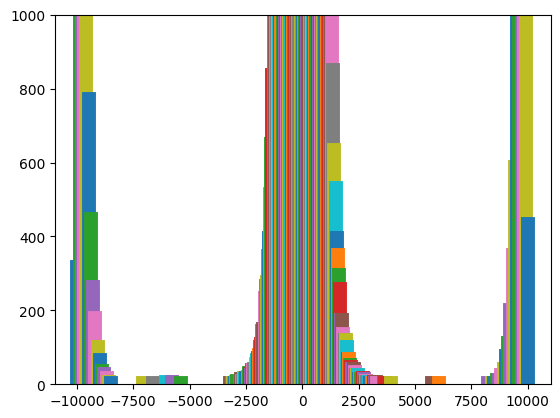

In [24]:
for i in range(len(ranges)):
    plt.plot([np.mean(ranges[i]), np.mean(ranges[i])], [0, nb_per_range[i]], linewidth=10)

plt.ylim([0, 1000])
plt.show()

In [25]:
# nb ranges with null pop
nb_per_range.count(0), round(nb_per_range.count(0)/len(nb_per_range), 2)

(158, 0.39)

In [26]:
nb_per_range__non_zero = list(filter(lambda x: x>0, nb_per_range))

In [27]:
np.min(nb_per_range__non_zero)

1

In [28]:
quantiles = np.quantile(nb_per_range__non_zero, [0.1, 0.25, 0.4, 0.5, 0.6, 0.75, 0.9])

In [29]:
np.array(quantiles, dtype=np.int64)

array([    1,     2,     5,    25,   101,  1058, 36023])

## Select positions from ranges where population > quantile_0.5

Let q = quantile 0.5 of the non_zero populations, we randomly pick min(2q, population_range) elements from this range

In [30]:
df = moves_df.sort_values(by="evaluation").reset_index(drop=True)

In [36]:
pct_q = 0.75
q = int(np.quantile(nb_per_range__non_zero, pct_q))
print(f"quantile {int(100*pct_q)}% -> {q}")

quantile 75% -> 1058


In [37]:
df

,evaluation,fen
0,-10000,8/k1N4p/5b2/p2p1p2/P7/1P4P1/K1R2P1P/r7 w - - 3 43
1,-10000,6k1/1p3pp1/4p2p/1Rn1R2P/7r/P5N1/5PPK/2r5 w - -...
2,-10000,8/8/8/4p1Qp/p7/P6k/8/4q1K1 w - - 28 73
3,-10000,2r2bk1/ppr2pp1/7p/2PpR2N/P2Bb3/2P4P/5Pq1/1R1Q2...
4,-10000,6Q1/4r2p/3p2pk/8/8/4p3/4BnPP/6RK w - - 1 53
...,...,...
6878598,10000,3r4/1pq3p1/3pn1kr/1pPPpQ1p/P5P1/2B1PK2/6P1/RN2...
6878599,10000,5Q2/1R2n2p/2P2Np1/4r2k/7P/4P1Pb/5P2/q4BK1 b - ...
6878600,10000,8/2r4p/p4p2/1p2bp2/8/6k1/P5PQ/3B2K1 b - - 3 50
6878601,10000,8/5Q2/p3k1P1/2p5/2Np1b2/1P6/P6q/3K4 b - - 12 52


In [38]:
df_picked = pd.DataFrame()

In [39]:
for i in tqdm(range(len(ranges))):
    range_ = ranges[i]
    nb_range = nb_per_range[i]
    nb_to_sample = min(2*q, nb_range)
    df_range_picked = df.loc[df.evaluation.isin(range_)].sample(nb_to_sample)
    df_picked = pd.concat([df_picked, df_range_picked])

100%|██████████| 401/401 [00:27<00:00, 14.50it/s]


In [40]:
df_picked

,evaluation,fen
260,-10000,8/p5kp/3p2p1/8/3b2n1/2P5/PP4Bq/5R1K w - - 0 43
24,-10000,2r4k/6np/p2p1b2/2pP4/2P1NB2/R2Q4/1r4qP/5R1K w ...
123,-10000,2rr2k1/5ppp/1p1Rb3/pP6/P1P1pP2/Q1R1P2P/1N2K1n1...
272,-10000,7k/R3b1pp/1pb5/2p4Q/P3p3/1PN1R1P1/1B1P1r1K/5q2...
294,-10000,K7/2q5/3k4/P7/4b3/8/8/8 w - - 10 61
...,...,...
6878500,10000,r3rkQ1/pp1n3p/2p5/q7/2BP4/7P/P5P1/K2bR3 b - - ...
6878186,10000,2k2R2/8/1PP5/8/7r/1K3p2/8/8 b - - 1 49
6878401,10000,1r3n2/1p4Q1/p1p3pk/P7/1P2P1K1/6P1/1B3q1P/4R3 b...
6878493,10000,4q3/5R2/P2p1Np1/4p3/4P1kp/r7/3Q2K1/8 b - - 3 58


In [ ]:
to_csv(df_picked, "")